# Assignment 5

**Submission deadline:**
* **Normal problems: Thursday, 28.05.2020**
* **Bonus problems: Deadline of Assignment 6**

**Points: 10 + 7+ bonus points**


The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Add your solutions to the notebook.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

In [ ]:
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers

     |████████████████████████████████| 1.1MB 6.2MB/s 
     |████████████████████████████████| 890kB 21.3MB/s 
     |████████████████████████████████| 665kB 6.0MB/s 
     |████████████████████████████████| 3.8MB 27kB/s 


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import collections

import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint
import gensim

import io
from tqdm.autonotebook import tqdm


import torch


import tabulate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Problem 1: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Task
You will use word vectors pre-computed on a large dataset.
* **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
* **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

* **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
* **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Subtask 1: Analogies

In [ ]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [ ]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [ ]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [ ]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [ ]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #
    r2_pred = r1 + (q2 - q1)
    
    
    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred/np.sqrt(np.sum(r2_pred**2))
    vecs_norm = vecs.vec/np.sqrt(np.sum(vecs.vec**2,axis=1)).reshape(-1, 1)
    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [ ]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [ ]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## Subtask 2: translation through alignment of vector spaces

In [ ]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [ ]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [ ]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

In [ ]:
W.shape

(300, 300)

In [ ]:
def translate(W, v, vecs2):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #
    pl_v = v.dot(W)

    pl_v_norm = pl_v / np.sqrt(np.sum(pl_v**2))
    vecs_norm = vecs2.vec / np.sqrt(np.sum(vecs2.vec**2, axis=1)).reshape(-1, 1)
    idx = np.argmax(pl_v_norm.dot(vecs_norm.T))

    return vecs2.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

---------  ---------------
descent    calado
linked     powiązany
bishop     burmistrz
reviews    recenzje
sort       coś
comedy     komediowa
mean       powiedzieć
highly     bardzo
computer   oprogramowanie
ocean      morza
otherwise  koniecznie
auto       daimlerchrysler
covers     okładka
animals    zwierzęta
awarded    przyznana
oct        fotografiach
drums      klawiszowe
machine    urządzenia
georgia    olter
finally    dopiero
---------  ---------------


## Subtask 3: PCA

In [ ]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [ ]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


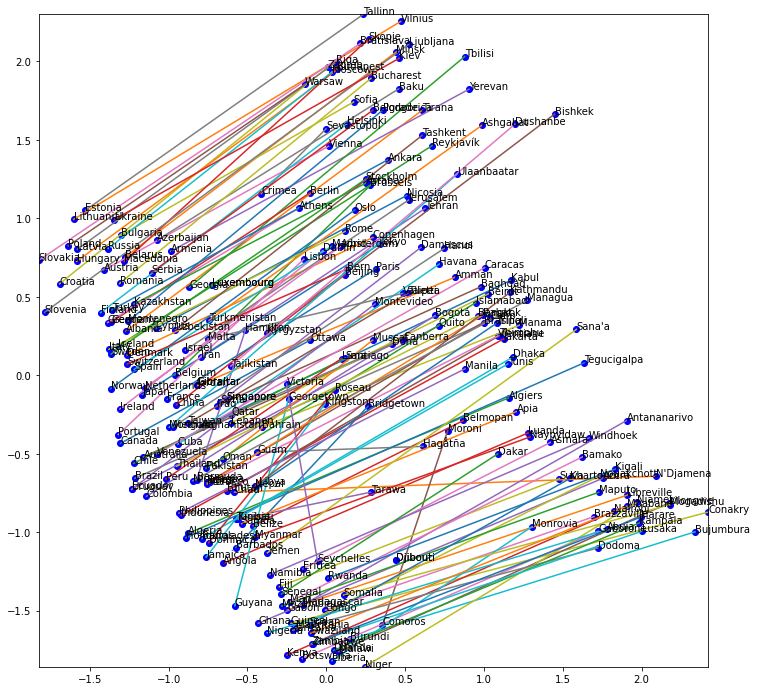

In [ ]:
from sklearn.decomposition import PCA

#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#
pca = PCA(n_components=2, whiten=True)
pos = pca.fit_transform(geo_vecs)

plt.figure(figsize=(12, 12))
plt.xlim(np.min(pos[:,0]), np.max(pos[:,0]))
plt.ylim(np.min(pos[:,1]), np.max(pos[:,1]))
for i, p in enumerate(pos):
    plt.annotate(geo[i], p)
    plt.scatter(p[0], p[1], c='b')
    if i % 2 == 0:
        plt.plot([p[0], pos[i+1][0]], [p[1], pos[i+1][1]])

## Subtask 4: PCA vs t-SNE on frequent words

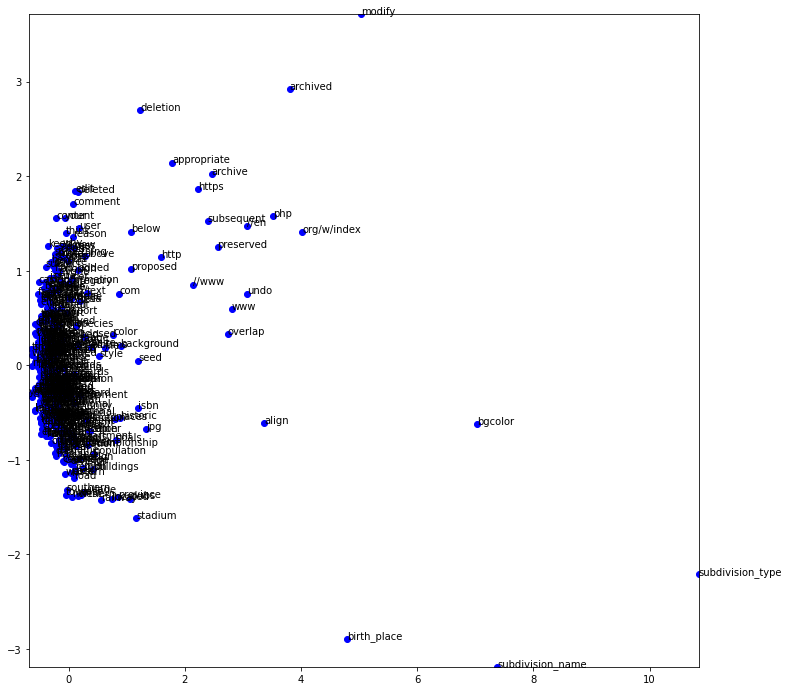

In [ ]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]


#
# TODO: make a 2D PCA projection of the selected words.
#
positions = ftext.vec[top_inds]
pca = PCA(n_components=2)
pos = pca.fit_transform(positions)

plt.figure(figsize=(12, 12))
plt.xlim(np.min(pos[:,0]), np.max(pos[:,0]))
plt.ylim(np.min(pos[:,1]), np.max(pos[:,1]))
for i, p in enumerate(pos):
    plt.annotate(top_words[i], p)
    plt.scatter(p[0], p[1], c='b')

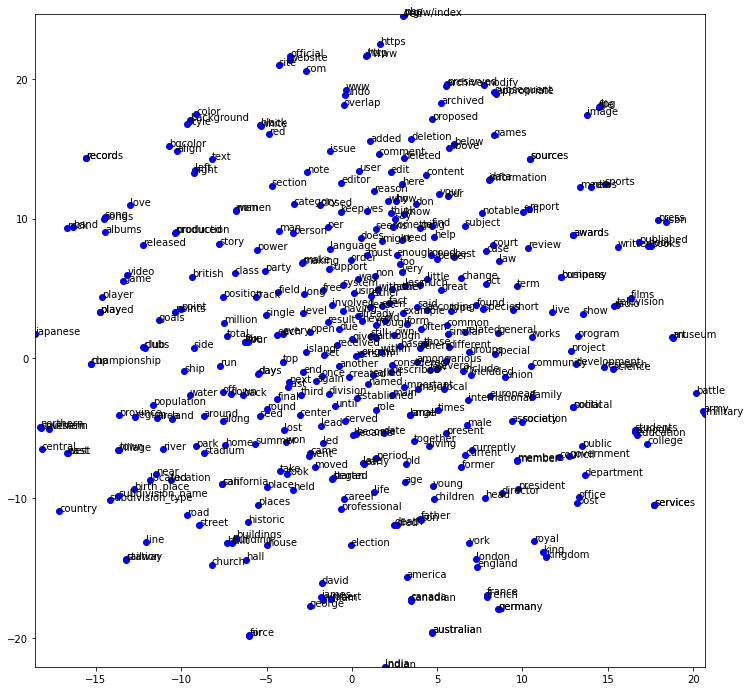

In [ ]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#
positions = ftext.vec[top_inds]
tsne = TSNE(n_components=2)
pos = tsne.fit_transform(positions)

plt.figure(figsize=(12, 12))
plt.xlim(np.min(pos[:,0]), np.max(pos[:,0]))
plt.ylim(np.min(pos[:,1]), np.max(pos[:,1]))
for i, p in enumerate(pos):
    plt.annotate(top_words[i], p)
    plt.scatter(p[0], p[1], c='b')

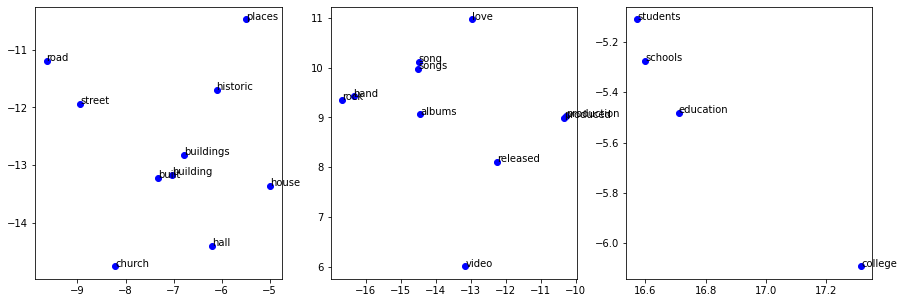

In [ ]:
# TODO: zomm in on 3 meaningful clusters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, p in enumerate(pos):
    if -10 < p[0] < -4 and -16 < p[1] < -10:
        axes[0].annotate(top_words[i], p)
        axes[0].scatter(p[0], p[1], c='b')
    if -17 < p[0] < -10 and 6 < p[1] < 13:
        axes[1].annotate(top_words[i], p)
        axes[1].scatter(p[0], p[1], c='b')
    if 15 < p[0] < 20 and -8 < p[1] < -2:
        axes[2].annotate(top_words[i], p)
        axes[2].scatter(p[0], p[1], c='b')

plt.show()

# Problem 2: kNN Talker [6p + 7bp]

In this exercise you will build a simple chatbot that uses distributed representations of words and sentences to perform a neares neighbor selection of responses.

We have collected two sets of data:
- `./reddit_pairs.txt` of excerpts of [Reddit](https://www.reddit.com/) conversations,
- `./hackernews_pairs.txt` of excertps from [Hackernews](https://news.ycombinator.com/).

The two corpuses are formatted as `tab`-separated pairs of utterances: a `prompt` and a `response`. Successive lines belong to different conversations.

The main idea of the chatbot is to build a representation of the user `input` and of all `prompts` from the corpus. Then select the best (or randomly one of the top few) matches and print the associated `response`.

The key to get the bot working is to create good sentence representations. We will try:
- averaging word embeddings
- using sentence models such as BERT.

### Warning:
The Reddit corpus may contain abusive language, it was not heavily cleaned.

### Tasks
The code below is a starting point, but you can develop you own. The following list suggests some actions to try, along with the points that reflect our subjective hardness. The exercise is worth 6 regular points (i.e. the report, word embedding-based model and BERT-based model), anything on top of it will be counted as a bonus.

1. [MANDATORY] type in a Markdown cell a report of your actions, what did you try, why, what was the result. Show exemplary conversations (they must be probable under your model) [2p].
2. Represent sentences by averaging their word vectors. Properly handle tokenization (you can use regular expressions or e.g. `nltk` library). Describe how you handle lower and upper cased words. Try a few nearest neighbor selection methods (such as euclidean or cosine distance). See how embedding normalization affects the results (you can normalize individual word vectors, full sentence vectors etc.) [2p]
3. Use the [transformers](https://huggingface.co/transformers) package to load a pretrained BERT model. Use it to represent sentences by e.g. averaging the activations in the last layer [2p].
4. Cherry-pick 3 nice dialogues [1p].
5. Incoportate context: keep a running average of past conversation turns [1p].
6. Do data cleaning, finding rules for good responses [1p].
7. Do profanity cleaning [1p].
8. Try mixing different sentence representation techniques [1p].
9. Try to custer responses to the highest scored prompts. Whic arsponses are more funny: form the largerst or from the smalles cluster? [2p].
10. Implement your own enhancements [?bp].


### Raport
To produce an answer I get a softmax of 3 best scores.

##### When representing sentence as average of word embeddings in Word2VecEncode:
- ignore stopwords
- convert sentences to lowercase
- remove all characters other than letters and digits
- if word not in dictionary return vector of zeros (when given a word we don't know act like it was never there)

##### Compare produced outputs when using cosine/euklidean distance with/without normalization:
- cosine vs euklidean:
    - 5 best answers usually are the same, sometimes 1 or 2 differs
    - ordering is different
- with vs without normalization:
    - I couldn't find a difference either in order or answer selection, results are the same

##### When using BERT:
- encode sentence using BERT Tokenizer and get activation of the last layer for each token. Because size depends on the length of the sentence represent it as a vector of mean values.
- to speed up encodings compute on CUDA

#### Some examples:
conversation from OneHotEncoder used prompts and answers from hackernews, the other two used data from reddit.

Talker's responses starts with `-` sign.

##### Conversation got from OneHotEncoder:
```
English?
- No.
Any jobs for junior developers?
- Of course not, that would be ridiculous.
Lol
- Indeed.
Can you be more professional?
- Arsenic, cadmium, lead, polyvinyl fluoride, and probably more.
```

##### Some conversations using Word2VecEncoder:
```
- awesome you're amazing
awesome you are great
- awesome?
very awesome
- hmm, is windows 8 awesome though?
surely it is better than windows vista
- 95 sry:(
continue about windows 95
- 95 sry:(
98 not really sorry
- ok no worries
thanks that means a lot for me
- no problem
you are really a hero
- a real human bean
how does it feel to be a human bean
- a real hero...
a real hero human bean
- and a real hero
```

##### Some conversations using BertEncoder:
```
- chipset
chipset?
- haha sorry ps4
or maybe xbox
- ^^cool
xbox is cool
- yes xbox
so xbox is better than play station right?
- a kinect camera
fair point
```

```
- no it's not. it's missing a few coins
you need the money to play?
- uh, yeah.
how much money
- quick give him 2 pennies
2 pennies and i can play as long as i want to?
- depends on the cards
seams cool
- thank god for that right?  what a mess that could have been.
and what we are going to do later
- maybe they post the patch notes today. then you can see if it ends, or not :)
looks like a great plan
- thanks mate, hoping to see you there!
```
When using encodings from BERT acivations conversations made more sense. It still was quite random sometimes but given answers more often compared to Word2Vec embeddings.

*Also I wrote an email asking to get first assignment graded but unfortunately I didn't get any response. When submiting I forgot to make it public and you couldn't grade it back then. Could you check that, please? Unexpectedly I was poked with cushions by some people reffering to themselves as 'Spanish Inquisition'.*


In [ ]:
prompts = []
responses = []
err_lines = []
with open('./hackernews_pairs.txt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        line = line.split('\t')
        if len(line)!=2:
            err_lines.append(line)
        else:
            prompts.append(line[0])
            responses.append(line[1])
print(f"Failed to parse the following {len(err_lines)} lines: {err_lines}") 
print(f"Sample dialogue pairs: \n{pprint.pformat(list(zip(prompts[:15], responses)))}")

Failed to parse the following 0 lines: []
Sample dialogue pairs: 
[('Ah, yep, that was the issue.',
  'Yeah, options typically cost the company very little.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Oh, I see.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Whaaa?'),
 ('Quite cool.', 'It gets into a pretty philosophical area.'),
 ("If only the packaging smells, then I agree, it's not damaged.",
  'Sounds like entitlement to me.'),
 ("That's what nationalist politics always says.", 'Can you prove that?'),
 ('Misleading title.', 'Not really.'),
 ('Misleading title.',
  'It is not completely misleading to all users but enough for me to say '
  'something.'),
 ('Why the hell is this getting downvoted?',
  "Because it's clear the person he's responding to understood that "
  'relationship.'),
 ("There's a web without ads.",
  'This just came to mind when you mentioned "ad tax".'),
 ('God 

In [ ]:
class BasicEncoder:
    def encode(self, sentence):
        # this is a base class!
        raise NotImplementedError

    def encode_corpus(self, sentences, normalize=True):
        ret = [self.encode(sentence, normalize=True) for sentence in tqdm(sentences)]
        return np.vstack(ret)

The code below implements a simple baseline: we encode each sentence as a sparse vector which sums word occurrences.

In [ ]:
class OneHotEncoder(BasicEncoder):
    def __init__(self, sentences):
        self.vectorizer = sklearn.feature_extraction.text.CountVectorizer()
        self.vectorizer.fit(sentences)
    
    def encode(self, sentence):
        return self.vectorizer.transform([sentence])[0]

    def encode_corpus(self, sentences):
        # Override because sklearn already works on batches
        encodings = self.vectorizer.transform(sentences)
        # Note: this code needs to handle the scipy sparse matrix
        # which has subtle differences with numpy ndarrays
        norms = np.array((encodings.power(2)).sum(1))**0.5
        encodings = encodings.multiply(1.0 / (norms+1e-10))
        return encodings

encoder = OneHotEncoder(prompts)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Deal with encodings being sparse matrices. Word2vecs will not have the pecularities
scores = (encodings @ enc.T).toarray().ravel()
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

0.9999999999 Question. : In a sense 'maybe not'.
0.9999999999 Linux? : Unfortunately not.
0.9999999999 Windows? : Unix based systems
0.9999999999 Question. : This is a good question!
0.8017837257158447 Hardware or software or technique or best practices... : Mobile phones that still work when you drop them.
0.8017837257158447 Hardware or software or technique or best practices... : Floppy disk and cd/dvd drives!
0.8017837257158447 Hardware or software or technique or best practices... : Building your own desktop.
0.8017837257158447 Hardware or software or technique or best practices... : Extreme programming.
0.8017837257158447 Hardware or software or technique or best practices... : Zip drives.
0.8017837257158447 Hardware or software or technique or best practices... : It can all go.


In [ ]:
prompts = []
responses = []
err_lines = []
with open('./reddit_pairs.txt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        line = line.split('\t')
        if len(line)!=2:
            err_lines.append(line)
        else:
            prompts.append(line[0])
            responses.append(line[1])
print(f"Failed to parse the following {len(err_lines)} lines: {err_lines}") 
print(f"Sample dialogue pairs: \n{pprint.pformat(list(zip(prompts[:15], responses)))}")

Failed to parse the following 7 lines: [['1602 link karma', '11259 comment karma', 'damn you got almost all your karma here'], ['lol'], ['50$ skin pls'], ['omg his posting how'], ['11', 'inches to be precise :)', 'holy shit your girl has found herself a fuckin unicorn!'], ['( ) no fuk'], ['looks like you post on multiple porn subreddits']]
Sample dialogue pairs: 
[('show', 'me your moves?'),
 ('haters gonna hate', 'hate'),
 ('i think he is doing sarcasm.',
  'hahaha, you stupid twat, go and have a wank'),
 ('i can do 38 for void head :)', '39k man cant go for 38k'),
 ('brb getting hit by a car', 'did your mate, also buy you a computer?'),
 ('reason ?', 'to pay for bandwidth to troll people online.'),
 ('*155k notes...*', 'welcome to tumblr'),
 ('is it just me or is this pitched up?',
  'might be to avoid copyright issues.'),
 ('no chapter this week bud :(', '**cough*'),
 ("that's gonna come back for a block in the back",
  "but it doesn't matter. fuck this game. connor cook playing ful

In [ ]:
# TODO: build a simple dialogue system using these k-neares neighbor matches, 
# perform a few test conversations

### Word2VecEncoder

In [ ]:
import re


class Word2VecEncoder(BasicEncoder):
    def __init__(self, vecs):
        self._vecs = vecs
        self.stop_words = nltk.corpus.stopwords.words('english')
        
    def _get_vec(self, word):
        # Find the vector for word, or use a suitable out-of-vocabulary vector
        # For extra points try backing off to a lowercased dictionary

        if word not in self._vecs.word2idx:  # if not in dictionary return zeros
            return self._vecs.vec[0] * 0
        else:
            idx = self._vecs.word2idx[word]
            return word2vec.vec[idx]

    def preprocess(self, word):
        word = word.lower()
        cleaned = re.sub(r'\W', '', word)

        if word in self.stop_words:
            return None

        return word


    def encode(self, sentence, normalize=True):
        ret = np.zeros(self._vecs.vec.shape[1])
        for token in nltk.tokenize.word_tokenize(sentence):
            word = self.preprocess(token)
            if word is None:
                continue
            word_vec = self._get_vec(word)
            ret += word_vec

        if normalize:
            ret /= (np.linalg.norm(ret) + 1e-5)
        return ret

encoder = Word2VecEncoder(word2vec)
encodings_norm = encoder.encode_corpus(prompts)
encodings = encoder.encode_corpus(prompts, normalize=False)

In [ ]:
def compare(encodings, encodings_norm):
    while True:
        prompt = input()
        if prompt == '':
            break

        enc = encoder.encode(prompt)
        enc_norm = encoder.encode(prompt)

        scores = (encodings @ enc.T).ravel()
        top_idx = scores.argsort()[-5:]

        print('- cosine:')
        for idx in top_idx:
            print(f'\t {responses[idx]}')

        scores = (encodings_norm @ enc_norm.T).ravel()
        top_idx = scores.argsort()[-5:]

        print('- cosine norm:')
        for idx in top_idx:
            print(f'\t {responses[idx]}')


        scores = np.sum((encodings - enc)**2, axis=1)
        top_idx = scores.argsort()[:5]

        print('- euclidean')
        for idx in top_idx:
            print(f'\t {responses[idx]}')    

        scores = np.sum((encodings_norm - enc_norm)**2, axis=1)
        top_idx = scores.argsort()[:5]

        print('- euclidean norm')
        for idx in top_idx:
            print(f'\t {responses[idx]}')
        
        print('\n'*2)

In [ ]:
compare(encodings, encodings_norm)

hi how are you
- cosine:
	 hola
	 thanks
	 x.x
	 funny and awesome yo
	 chills af
- cosine norm:
	 hola
	 thanks
	 x.x
	 funny and awesome yo
	 chills af
- euclidean
	 yes
	 sup
	 hello alex
	 le!
	 hi.
- euclidean norm
	 yes
	 sup
	 hello alex
	 le!
	 hi.



high school musical
- cosine:
	 yea school...
	 you fucking asshole :)
	 did you not?
	 but could they beat the knicks?
	 see above
- cosine norm:
	 yea school...
	 you fucking asshole :)
	 did you not?
	 but could they beat the knicks?
	 see above
- euclidean
	 see above
	 but could they beat the knicks?
	 did you not?
	 what's school
	 brb moving to your school
- euclidean norm
	 see above
	 but could they beat the knicks?
	 did you not?
	 what's school
	 brb moving to your school



come on be polite
- cosine:
	 i doubt it
	 3 weeks it is.
	 not sure if that's supposed to be sarcastic, lmao.
	 how do this if you cant speak the same language
	 ur m0m is an polite
- cosine norm:
	 i doubt it
	 3 weeks it is.
	 not sure if that's 

In [ ]:
def dialogue(encoder, encodings, dist_measure='cosine', normalize=True):
    while True:
        prompt = input()
        if prompt == '':
            break

        enc = encoder.encode(prompt)
        if normalize:
            enc /= (np.linalg.norm(enc) + 1e-5)

        if dist_measure == 'cosine':
            scores = (encodings @ enc.T).ravel()
        elif dist_measure == 'euklidean':
            scores = np.sum((encodings - enc)**2, axis=1)
            scores = 1/(scores+1e-10)
        else:
            ValueError('dist measure has to be either "cosine" or "euklidean"')

        top_idx = scores.argsort()[-3:]
        if np.sum(scores) == 0:
            scores = scores + 1/3

        ans_idx = np.random.choice(top_idx, p=scores[top_idx]/np.sum(scores[top_idx]))
        ans = responses[ans_idx]

        print(f'- {ans}')

In [ ]:
dialogue(encoder, encodings_norm)

hi how are you
- funny and awesome yo
i will treat that as a good response
- actually, it's pretty darn scary to me....
why it is scary
- 3spooky5me
ok alright
- i like teemo but no one will see this
did you try to google that
- who am i
ruthless
- what happened
what do you think happened
- that was a rather large explosion
and what exploded
- all
all of what
- oh ok
all of what
- oh ok
i see. you act unapproachable
- that's what i'm saying, some people man
some people woman too
- 8=====) (======8  = no babies.
well, hard to argue with that 
- the fuck does that mean?
which part you did not understand
- congrats on being 1337
i tried to be 1336
- win some lose some, i take my l
what did you lose
- *woosh*
swoosh
- whoosh
ambush
- okay. ty!
native americans
- ...gays?
why do you think they were gays
- idk gay i think
nothing wrong with that right?
- awesome you're amazing
awesome you are great
- awesome?
very awesome
- hmm, is windows 8 awesome though?
surely it is better than windows v

### BERT

In [ ]:
from transformers import BertModel, BertTokenizer

In [ ]:
class BertEncoder(BasicEncoder):

    def __init__(self, model, tokenizer):
        self.model = model
        self.model.to('cuda')
        self.tokenizer = tokenizer

    def encode(self, sentence, normalize=True):
        tokenized = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).unsqueeze(0)
        tokenized = tokenized.to('cuda')
        with torch.no_grad():
            outputs = model(tokenized)[0]
        outputs = outputs.to('cpu')
        ret = outputs[0].detach().numpy()
        ret = np.mean(ret, axis=0)

        if normalize:
            ret /= (np.linalg.norm(ret) + 1e-5)
        return ret


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

encoder = BertEncoder(model, tokenizer)
encodings_norm = encoder.encode_corpus(prompts)

In [ ]:
dialogue(encoder, encodings_norm)

NameError: ignored

In [ ]:
# used on encodings from hackernews
prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)
enc /= (np.linalg.norm(enc) + 1e-5)

scores = (encodings_norm @ enc.T).ravel()
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

0.80417264 Feature or bug? : Feature, obviously.
0.7970118 Side question: is there any similar cloud service with hard billing caps? : I'd really love to know.
0.7871805 No linux client? : There is a web client for it.
0.7871805 No linux client? : Wait a week, someone will develop one.
0.7711021 Is that rate limit hardware based? : Hardware.
0.7705529 The challenging question is: do you have kids? : One kid, lives with my ex-wife.
0.7698417 Honest question, what is reverse racism? : Depends on where you stand on identity politics.
0.7698417 Honest question, what is reverse racism? : I've heard it used often in conjunction with benefits given to minorities.
0.76673627 What browser do you recommend then for real security? : The browser is not the question.
0.76515853 what about os x server? : OS X server mail setup is easy.
